# InsightFace LFW Benchmark

This notebook benchmarks the InsightFace buffalo_l model on the LFW (Labeled Faces in the Wild) dataset.

## Objectives:
- Download LFW dataset from Kaggle
- Select 50 genuine pairs and 50 imposter pairs
- Extract face embeddings using InsightFace buffalo_l
- Compute evaluation metrics: TAR, FAR, EER at threshold 0.6
- Measure average inference time

In [4]:
# Install required packages
import subprocess
import sys

packages = [
    'kaggle',
    'insightface',
    'onnxruntime',
    'onnx',
    'opencv-python',
    'numpy',
    'scipy',
    'pandas',
    'tqdm'
]

for package in packages:
    try:
        # Special handling for kaggle - it tries to authenticate on import
        if package == 'kaggle':
            try:
                import kaggle
                print(f"✓ {package} is already installed")
            except (ImportError, OSError):
                # OSError occurs when kaggle.json is missing, but package is installed
                print(f"✓ {package} is installed (authentication may be required later)")
        else:
            __import__(package.replace('-', '_'))
            print(f"✓ {package} is already installed")
    except ImportError:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        print(f"✓ {package} installed successfully")

✓ kaggle is installed (authentication may be required later)
Installing insightface...
✓ insightface installed successfully
Installing onnxruntime...
✓ onnxruntime installed successfully
✓ onnx is already installed
Installing opencv-python...
✓ opencv-python installed successfully
✓ numpy is already installed
✓ scipy is already installed
✓ pandas is already installed
✓ tqdm is already installed


## Step 1: Import Required Libraries

In [6]:
import os
import sys
import cv2
import numpy as np
import pandas as pd
from pathlib import Path
from scipy.spatial.distance import cosine
from scipy.optimize import brentq
from scipy.interpolate import interp1d
import time
from tqdm import tqdm
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Set data path
data_path = Path("./lfw-dataset")
if not data_path.exists():
    data_path.mkdir(parents=True, exist_ok=True)

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


## Step 2: Download and Extract LFW Dataset from Kaggle

**Note:** You need to have Kaggle API credentials set up. Choose one of the following methods:

### Method 1: Environment Variables (Recommended for notebooks/cloud)
1. Go to https://www.kaggle.com/settings/account
2. Click "Create New API Token" 
3. This will download `kaggle.json` - open it to get your username and key
4. Set environment variables:
   ```python
   import os
   os.environ['KAGGLE_USERNAME'] = 'your_username'
   os.environ['KAGGLE_KEY'] = 'your_api_key'
   ```

### Method 2: kaggle.json File
1. Go to https://www.kaggle.com/settings/account
2. Click "Create New API Token" 
3. This will download `kaggle.json` to your Downloads folder
4. Place it in:
   - Windows: `C:\Users\<YourUsername>\.kaggle\kaggle.json`
   - Linux/Mac: `~/.kaggle/kaggle.json`
   - On Linux/Mac, set permissions: `chmod 600 ~/.kaggle/kaggle.json`

In [12]:
# OPTIONAL: Set Kaggle credentials using environment variables
# Uncomment and fill in your credentials below, or use Method 2 (kaggle.json file)
# Get your credentials from: https://www.kaggle.com/settings/account

import os

# Uncomment and fill in your credentials:
os.environ['KAGGLE_USERNAME'] = 'votrucho'
os.environ['KAGGLE_KEY'] = 'KGAT_8afdcfd978581f310f2881d352c3e19f'

# If you've set the variables above, you can verify them:
if 'KAGGLE_USERNAME' in os.environ and 'KAGGLE_KEY' in os.environ:
    print("✓ Kaggle credentials found in environment variables")
    print(f"  Username: {os.environ['KAGGLE_USERNAME']}")
    print(f"  Key: {os.environ['KAGGLE_KEY'][:10]}... (hidden)")
else:
    print("ℹ No environment variables set. Will use kaggle.json file method if available.")

✓ Kaggle credentials found in environment variables
  Username: votrucho
  Key: KGAT_8afdc... (hidden)


In [16]:
import os
from pathlib import Path
import zipfile
import subprocess

# Check if dataset already exists
lfw_path = Path("./lfw-dataset")

if not (lfw_path / "lfw").exists():
    print("LFW dataset not found. Attempting to download from Kaggle...")
    
    # Check if environment variables are set (Method 1)
    kaggle_username = os.getenv('KAGGLE_USERNAME')
    kaggle_key = os.getenv('KAGGLE_KEY')
    
    if kaggle_username and kaggle_key:
        print("✓ Found Kaggle credentials in environment variables")
        # Environment variables are already set, Kaggle API will use them automatically
    else:
        print("ℹ No environment variables found. Will try kaggle.json file method...")
    
    # Check if kaggle is available
    try:
        from kaggle.api.kaggle_api_extended import KaggleApi
        api = KaggleApi()
        
        # If environment variables are set, configure them
        if kaggle_username and kaggle_key:
            api.set_config_value('username', kaggle_username)
            api.set_config_value('key', kaggle_key)
        
        api.authenticate()
        print("✓ Kaggle API authenticated successfully")
        
        # Download dataset
        print("Downloading LFW dataset from Kaggle...")
        result = subprocess.run(
            ["kaggle", "datasets", "download", "-d", "jessicali9530/lfw-dataset", "-p", "./lfw-dataset"],
            capture_output=True,
            text=True
        )
        
        if result.returncode != 0:
            print(f"Error downloading dataset: {result.stderr}")
            print("\nIf you see authentication errors, please use one of these methods:")
            print("\nMethod 1 - Environment Variables (recommended for notebooks):")
            print("  Set these before running this cell:")
            print("  os.environ['KAGGLE_USERNAME'] = 'your_username'")
            print("  os.environ['KAGGLE_KEY'] = 'your_api_key'")
            print("\nMethod 2 - kaggle.json file:")
            print(f"  Windows: C:\\Users\\{os.getenv('USERNAME', 'YourUsername')}\\.kaggle\\kaggle.json")
            print(f"  Linux/Mac: ~/.kaggle/kaggle.json")
        else:
            print("✓ Download completed")
    except Exception as e:
        error_msg = str(e)
        print(f"Error with Kaggle API: {error_msg}")
        
        if "kaggle.json" in error_msg.lower() or "could not find" in error_msg.lower():
            print("\n⚠ Authentication failed. Please set up credentials using one of these methods:")
            print("\n📌 Method 1 - Environment Variables (Recommended):")
            print("  Run this in a cell BEFORE this one:")
            print("  ```python")
            print("  import os")
            print("  os.environ['KAGGLE_USERNAME'] = 'your_username'  # From kaggle.json")
            print("  os.environ['KAGGLE_KEY'] = 'your_api_key'        # From kaggle.json")
            print("  ```")
            print("\n📌 Method 2 - kaggle.json file:")
            print("  1. Go to https://www.kaggle.com/settings/account")
            print("  2. Click 'Create New API Token'")
            print("  3. Place kaggle.json in:")
            print(f"     Windows: C:\\Users\\{os.getenv('USERNAME', 'YourUsername')}\\.kaggle\\kaggle.json")
            print(f"     Linux/Mac: ~/.kaggle/kaggle.json")
            print("  4. On Linux/Mac, set permissions: chmod 600 ~/.kaggle/kaggle.json")
        else:
            print("\nPlease check your Kaggle credentials. See Cell 4 for setup instructions.")
        
        print("\nAlternatively, you can manually download the dataset and extract it to ./lfw-dataset/")
    
    # Extract the zip file if it exists
    zip_files = list(lfw_path.glob("*.zip"))
    if zip_files:
        print(f"\nFound {len(zip_files)} zip file(s). Extracting...")
        for zip_file in zip_files:
            try:
                with zipfile.ZipFile(zip_file, 'r') as zip_ref:
                    zip_ref.extractall(lfw_path)
                print(f"✓ Extracted {zip_file.name}")
            except Exception as e:
                print(f"Error extracting {zip_file.name}: {e}")
    else:
        print("No zip files found to extract.")
else:
    print("✓ LFW dataset already exists locally")

# Check extracted structure - handle both 'lfw' and 'lfw-deepfunneled' folder names
lfw_folder = None
possible_folders = [lfw_path / "lfw-deepfunneled", lfw_path / "lfw"]  # Check deepfunneled first

for folder in possible_folders:
    if folder.exists() and folder.is_dir():
        # Verify it actually contains subdirectories (identities)
        subdirs = [d for d in folder.iterdir() if d.is_dir()]
        if len(subdirs) > 0:
            lfw_folder = folder
            break

if lfw_folder:
    print(f"\n✓ LFW folder found at {lfw_folder}")
    
    # Count identities (subdirectories)
    identities = [d for d in lfw_folder.iterdir() if d.is_dir()]
    num_identities = len(identities)
    
    # Count images - try multiple patterns
    num_images = 0
    image_patterns = ["*/*.jpg", "*/*.JPG", "*/*.jpeg", "*/*.JPEG", "*/*.png", "*/*.PNG"]
    for pattern in image_patterns:
        images = list(lfw_folder.glob(pattern))
        if images:
            num_images = len(images)
            break
    
    # If no images found with standard pattern, try recursive search
    if num_images == 0:
        all_images = list(lfw_folder.rglob("*.jpg")) + list(lfw_folder.rglob("*.JPG"))
        num_images = len(all_images)
    
    print(f"  - Number of identities: {num_identities}")
    print(f"  - Number of images: {num_images}")
    
    # Show sample structure for debugging
    if num_identities > 0 and num_images == 0:
        print("\n  ⚠ Warning: Found identities but no images. Checking structure...")
        sample_identity = identities[0]
        sample_files = list(sample_identity.iterdir())
        print(f"  Sample identity folder: {sample_identity.name}")
        print(f"  Files in sample folder: {len(sample_files)}")
        if sample_files:
            print(f"  Sample file: {sample_files[0].name}")
else:
    print("\n⚠ Warning: LFW folder not found after download/extraction.")
    print("Checking available folders and files...")
    if lfw_path.exists():
        items = list(lfw_path.iterdir())
        if items:
            print("Found:")
            for item in items:
                if item.is_dir():
                    print(f"  📁 {item.name}/")
                else:
                    print(f"  📄 {item.name}")
        else:
            print("  (empty directory)")
    else:
        print("  (directory does not exist)")

✓ LFW dataset already exists locally

✓ LFW folder found at lfw-dataset/lfw-deepfunneled
  - Number of identities: 1
  - Number of images: 13233


## Step 3: Load and Prepare Known (Genuine) and Imposter (Non-Match) Pairs

In [17]:
from pathlib import Path
import random

# Find LFW pairs file
lfw_path = Path("./lfw-dataset")

# Check for both possible folder names - prefer lfw-deepfunneled (actual folder) over symlink
lfw_folder = None
for folder_name in ["lfw-deepfunneled", "lfw"]:  # Check actual folder first
    candidate = lfw_path / folder_name
    if candidate.exists() and candidate.is_dir():
        # Verify it has subdirectories (identities)
        subdirs = [d for d in candidate.iterdir() if d.is_dir()]
        if len(subdirs) > 0:
            lfw_folder = candidate
            break

if lfw_folder is None:
    raise FileNotFoundError("Could not find LFW dataset folder. Please run Step 2 first.")

print(f"Using LFW folder: {lfw_folder}")

# List all available pairs files
pairs_files = list(lfw_path.glob("**/*pairs*.txt"))
print(f"Found pairs files: {pairs_files}")

# Read pairs file (usually pairs.txt or pairsDevTest.txt)
pairs_file = None
for candidate in [lfw_path / "pairsDevTest.txt", lfw_path / "pairs.txt"]:
    if candidate.exists():
        pairs_file = candidate
        break

if pairs_file is None:
    # Create pairs from available identities
    print("Creating synthetic pairs from available images...")
    
    # Get all images grouped by identity - try multiple patterns
    identity_images = defaultdict(list)
    
    # Try standard pattern first
    images = list(lfw_folder.glob("*/*.jpg")) + list(lfw_folder.glob("*/*.JPG"))
    
    # If no images found, try recursive search
    if len(images) == 0:
        images = list(lfw_folder.rglob("*.jpg")) + list(lfw_folder.rglob("*.JPG"))
    
    # If still no images, try other extensions
    if len(images) == 0:
        images = list(lfw_folder.rglob("*.jpeg")) + list(lfw_folder.rglob("*.png"))
    
    print(f"Found {len(images)} images total")
    
    for img_path in images:
        # Get the identity (parent folder name)
        identity = img_path.parent.name
        # Store relative path from lfw_folder
        rel_path = img_path.relative_to(lfw_folder)
        identity_images[identity].append(str(rel_path))
    
    # Filter identities with at least 2 images
    identities_with_multiple = {k: v for k, v in identity_images.items() if len(v) >= 2}
    identities_list = list(identities_with_multiple.keys())
    
    print(f"Found {len(identities_list)} identities with multiple images")
    
    # Create genuine pairs (same identity)
    genuine_pairs = []
    for _ in range(50):
        identity = random.choice(identities_list)
        images = identities_with_multiple[identity]
        if len(images) >= 2:
            img1, img2 = random.sample(images, 2)
            genuine_pairs.append((identity, img1, identity, img2, 1))  # 1 for genuine
    
    # Create imposter pairs (different identities)
    imposter_pairs = []
    while len(imposter_pairs) < 50:
        id1, id2 = random.sample(identities_list, 2)
        img1 = random.choice(identities_with_multiple[id1])
        img2 = random.choice(identities_with_multiple[id2])
        imposter_pairs.append((id1, img1, id2, img2, 0))  # 0 for imposter
    
    all_pairs = genuine_pairs + imposter_pairs
else:
    print(f"Reading pairs from {pairs_file}")
    
    # Parse pairs file
    all_pairs = []
    with open(pairs_file, 'r') as f:
        lines = f.readlines()[1:]  # Skip header
    
    genuine_pairs = []
    imposter_pairs = []
    
    for line in lines:
        parts = line.strip().split('\t')
        if len(parts) == 3:  # Genuine pair: name img1_idx img2_idx
            name, idx1, idx2 = parts
            img1 = f"{name}/{name}_{int(idx1):04d}.jpg"
            img2 = f"{name}/{name}_{int(idx2):04d}.jpg"
            if (lfw_folder / img1).exists() and (lfw_folder / img2).exists():
                genuine_pairs.append((name, img1, name, img2, 1))
        elif len(parts) == 4:  # Imposter pair: name1 idx1 name2 idx2
            name1, idx1, name2, idx2 = parts
            img1 = f"{name1}/{name1}_{int(idx1):04d}.jpg"
            img2 = f"{name2}/{name2}_{int(idx2):04d}.jpg"
            if (lfw_folder / img1).exists() and (lfw_folder / img2).exists():
                imposter_pairs.append((name1, img1, name2, img2, 0))
    
    # Sample 50 of each type
    if len(genuine_pairs) >= 50:
        genuine_pairs = random.sample(genuine_pairs, 50)
    if len(imposter_pairs) >= 50:
        imposter_pairs = random.sample(imposter_pairs, 50)
    
    all_pairs = genuine_pairs + imposter_pairs

print(f"\n✓ Loaded {len([p for p in all_pairs if p[4] == 1])} genuine pairs")
print(f"✓ Loaded {len([p for p in all_pairs if p[4] == 0])} imposter pairs")
print(f"✓ Total pairs: {len(all_pairs)}")

Using LFW folder: lfw-dataset/lfw-deepfunneled
Found pairs files: []
Creating synthetic pairs from available images...
Found 13233 images total
Found 1680 identities with multiple images

✓ Loaded 50 genuine pairs
✓ Loaded 50 imposter pairs
✓ Total pairs: 100


## Step 4: Initialize InsightFace Model (buffalo_l)

In [18]:
import insightface
from insightface.app import FaceAnalysis
import cv2

print("Initializing InsightFace model (buffalo_l)...")
# Initialize the FaceAnalysis with buffalo_l model
face_analyzer = FaceAnalysis(name='buffalo_l', providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])
face_analyzer.prepare(ctx_id=0, det_size=(640, 640))

print("✓ InsightFace model loaded successfully")

Initializing InsightFace model (buffalo_l)...
download_path: /root/.insightface/models/buffalo_l


100%|██████████| 281857/281857 [00:03<00:00, 81026.80KB/s] 


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
✓ InsightFac

## Step 5: Extract Face Embeddings for All Selected Pairs

In [29]:
import cv2
import numpy as np
from tqdm import tqdm
import time

def extract_embedding(image_path, face_analyzer):
    """Extract face embedding from an image"""
    try:
        img = cv2.imread(str(image_path))
        if img is None:
            return None
        
        faces = face_analyzer.get(img)
        if len(faces) == 0:
            return None
        
        # Get the embedding from the first detected face
        embedding = faces[0].embedding
        return embedding
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

# Extract embeddings for all pairs
print("Extracting embeddings for all pairs...")
embeddings_cache = {}
inference_times = []

# Find the correct LFW folder (handles both 'lfw' and 'lfw-deepfunneled')
# Prefer lfw-deepfunneled (actual folder) over symlink
lfw_base_path = Path("./lfw-dataset")
lfw_folder = None
for folder_name in ["lfw-deepfunneled", "lfw"]:  # Check actual folder first
    candidate = lfw_base_path / folder_name
    if candidate.exists() and candidate.is_dir():
        # Verify it has subdirectories (identities)
        subdirs = [d for d in candidate.iterdir() if d.is_dir()]
        if len(subdirs) > 0:
            lfw_folder = candidate
            break

if lfw_folder is None:
    raise FileNotFoundError("Could not find LFW dataset folder. Please run Step 2 first.")

print(f"Using LFW folder for embeddings: {lfw_folder}")

# Get all unique images first
unique_images = set()
for pair in all_pairs:
    unique_images.add(pair[1])  # img1
    unique_images.add(pair[3])  # img2

print(f"Extracting embeddings for {len(unique_images)} unique images...")

for img_path in tqdm(unique_images, desc="Extracting embeddings"):
    full_path = lfw_folder / img_path
    
    start_time = time.time()
    embedding = extract_embedding(full_path, face_analyzer)
    inference_time = time.time() - start_time
    
    if embedding is not None:
        embeddings_cache[img_path] = embedding
        inference_times.append(inference_time)

print(f"✓ Successfully extracted {len(embeddings_cache)} embeddings")
print(f"  Average inference time per image: {np.mean(inference_times):.4f} seconds")

Extracting embeddings for all pairs...
Using LFW folder for embeddings: lfw-dataset/lfw-deepfunneled
Extracting embeddings for 191 unique images...


Extracting embeddings: 100%|██████████| 191/191 [03:04<00:00,  1.04it/s]

✓ Successfully extracted 191 embeddings
  Average inference time per image: 0.9624 seconds


## Step 6: Calculate Similarity Scores Between Pairs

In [30]:
from scipy.spatial.distance import cosine
import numpy as np

def compute_similarity(emb1, emb2):
    """Compute cosine similarity between two embeddings"""
    # Normalize embeddings
    emb1_norm = emb1 / np.linalg.norm(emb1)
    emb2_norm = emb2 / np.linalg.norm(emb2)
    
    # Cosine similarity (1 - cosine distance)
    similarity = 1 - cosine(emb1_norm, emb2_norm)
    return similarity

# Calculate similarity scores for all pairs
print("Calculating similarity scores...")
scores = []
labels = []  # 1 for genuine, 0 for imposter

for pair in tqdm(all_pairs, desc="Computing similarities"):
    id1, img1_path, id2, img2_path, label = pair
    
    if img1_path in embeddings_cache and img2_path in embeddings_cache:
        emb1 = embeddings_cache[img1_path]
        emb2 = embeddings_cache[img2_path]
        
        similarity = compute_similarity(emb1, emb2)
        scores.append(similarity)
        labels.append(label)

scores = np.array(scores)
labels = np.array(labels)

print(f"✓ Computed {len(scores)} similarity scores")
print(f"  Genuine pairs: {np.sum(labels)} / {len(labels)}")
print(f"  Imposter pairs: {np.sum(labels == 0)} / {len(labels)}")
print(f"  Average similarity (genuine): {np.mean(scores[labels == 1]):.4f}")
print(f"  Average similarity (imposter): {np.mean(scores[labels == 0]):.4f}")

Calculating similarity scores...


Computing similarities: 100%|██████████| 100/100 [00:00<00:00, 20816.44it/s]

✓ Computed 100 similarity scores
  Genuine pairs: 50 / 100
  Imposter pairs: 50 / 100
  Average similarity (genuine): 0.6753
  Average similarity (imposter): -0.0054


## Step 7: Compute Evaluation Metrics (TAR, FAR, EER) at Threshold 0.6

In [31]:
import numpy as np
from scipy.interpolate import interp1d
from scipy.optimize import brentq

def calculate_metrics(scores, labels, threshold=0.6):
    """
    Calculate TAR, FAR, and EER
    
    TAR (True Acceptance Rate): Proportion of genuine pairs correctly identified
    FAR (False Acceptance Rate): Proportion of impostor pairs incorrectly accepted
    EER (Equal Error Rate): Threshold where FAR = FRR
    """
    
    # Separate genuine and impostor scores
    genuine_scores = scores[labels == 1]
    impostor_scores = scores[labels == 0]
    
    # TAR at threshold: True Positives / Total Genuine Pairs
    tar = np.sum(genuine_scores >= threshold) / len(genuine_scores) if len(genuine_scores) > 0 else 0
    
    # FAR at threshold: False Positives / Total Impostor Pairs
    far = np.sum(impostor_scores >= threshold) / len(impostor_scores) if len(impostor_scores) > 0 else 0
    
    # Calculate EER - find threshold where FAR = FRR
    # FRR (False Rejection Rate) = 1 - TAR
    thresholds = np.arange(0.0, 1.01, 0.001)
    tars = []
    fars = []
    frrs = []
    
    for t in thresholds:
        tar_t = np.sum(genuine_scores >= t) / len(genuine_scores) if len(genuine_scores) > 0 else 0
        far_t = np.sum(impostor_scores >= t) / len(impostor_scores) if len(impostor_scores) > 0 else 0
        frr_t = 1 - tar_t
        
        tars.append(tar_t)
        fars.append(far_t)
        frrs.append(frr_t)
    
    tars = np.array(tars)
    fars = np.array(fars)
    frrs = np.array(frrs)
    
    # Find EER as the point where FAR = FRR
    eer = None
    eer_threshold = None
    
    # Try to find the intersection point
    try:
        # Interpolate to find exact intersection
        f = interp1d(thresholds, np.abs(fars - frrs), kind='linear')
        eer_threshold = brentq(lambda x: np.interp(x, thresholds, fars) - np.interp(x, thresholds, frrs), 
                               0, 1)
        eer = np.interp(eer_threshold, thresholds, fars)
    except:
        # If interpolation fails, find closest point
        min_idx = np.argmin(np.abs(fars - frrs))
        eer = (fars[min_idx] + frrs[min_idx]) / 2
        eer_threshold = thresholds[min_idx]
    
    return tar, far, eer, eer_threshold

# Calculate metrics at threshold 0.6
THRESHOLD = 0.6
tar, far, eer, eer_threshold = calculate_metrics(scores, labels, THRESHOLD)

print("\n" + "="*50)
print("BENCHMARK RESULTS AT THRESHOLD = 0.6")
print("="*50)
print(f"True Acceptance Rate (TAR):  {tar:.4f} ({tar*100:.2f}%)")
print(f"False Acceptance Rate (FAR): {far:.4f} ({far*100:.2f}%)")
print(f"Equal Error Rate (EER):      {eer:.4f} ({eer*100:.2f}%) at threshold {eer_threshold:.4f}")
print("="*50)


BENCHMARK RESULTS AT THRESHOLD = 0.6
True Acceptance Rate (TAR):  0.8000 (80.00%)
False Acceptance Rate (FAR): 0.0000 (0.00%)
Equal Error Rate (EER):      0.0200 (2.00%) at threshold 0.1160


## Step 8: Measure Average Inference Time

In [32]:
import numpy as np

# Calculate inference time statistics
if len(inference_times) > 0:
    avg_inference_time = np.mean(inference_times)
    min_inference_time = np.min(inference_times)
    max_inference_time = np.max(inference_times)
    std_inference_time = np.std(inference_times)
    
    print("\n" + "="*50)
    print("INFERENCE TIME STATISTICS")
    print("="*50)
    print(f"Average Inference Time:   {avg_inference_time:.4f} seconds")
    print(f"Minimum Inference Time:   {min_inference_time:.4f} seconds")
    print(f"Maximum Inference Time:   {max_inference_time:.4f} seconds")
    print(f"Std Dev Inference Time:   {std_inference_time:.4f} seconds")
    print(f"Total Images Processed:   {len(inference_times)}")
    print("="*50)
else:
    print("No inference times recorded")


INFERENCE TIME STATISTICS
Average Inference Time:   0.9624 seconds
Minimum Inference Time:   0.7813 seconds
Maximum Inference Time:   2.6467 seconds
Std Dev Inference Time:   0.2764 seconds
Total Images Processed:   191


In [33]:
# Check current working directory (where files will be saved)
import os
print(f"Current working directory: {os.getcwd()}")
print(f"Files will be saved to this directory when you run the next cells.")

Current working directory: /content
Files will be saved to this directory when you run the next cells.


## Step 9: Generate Comprehensive Benchmark Report


COMPREHENSIVE BENCHMARK REPORT - INSIGHTFACE BUFFALO_L ON LFW DATASET
                  Model Dataset  Genuine Pairs  Imposter Pairs  Total Pairs  Threshold TAR @ Threshold FAR @ Threshold            EER EER Threshold Avg Inference Time (s)  Total Images
InsightFace (buffalo_l)     LFW             50              50          100        0.6 0.8000 (80.00%)  0.0000 (0.00%) 0.0200 (2.00%)        0.1160                 0.9624           191

✓ Report saved to: /content/benchmark_report.csv
✓ Visualization saved to: /content/benchmark_results.png


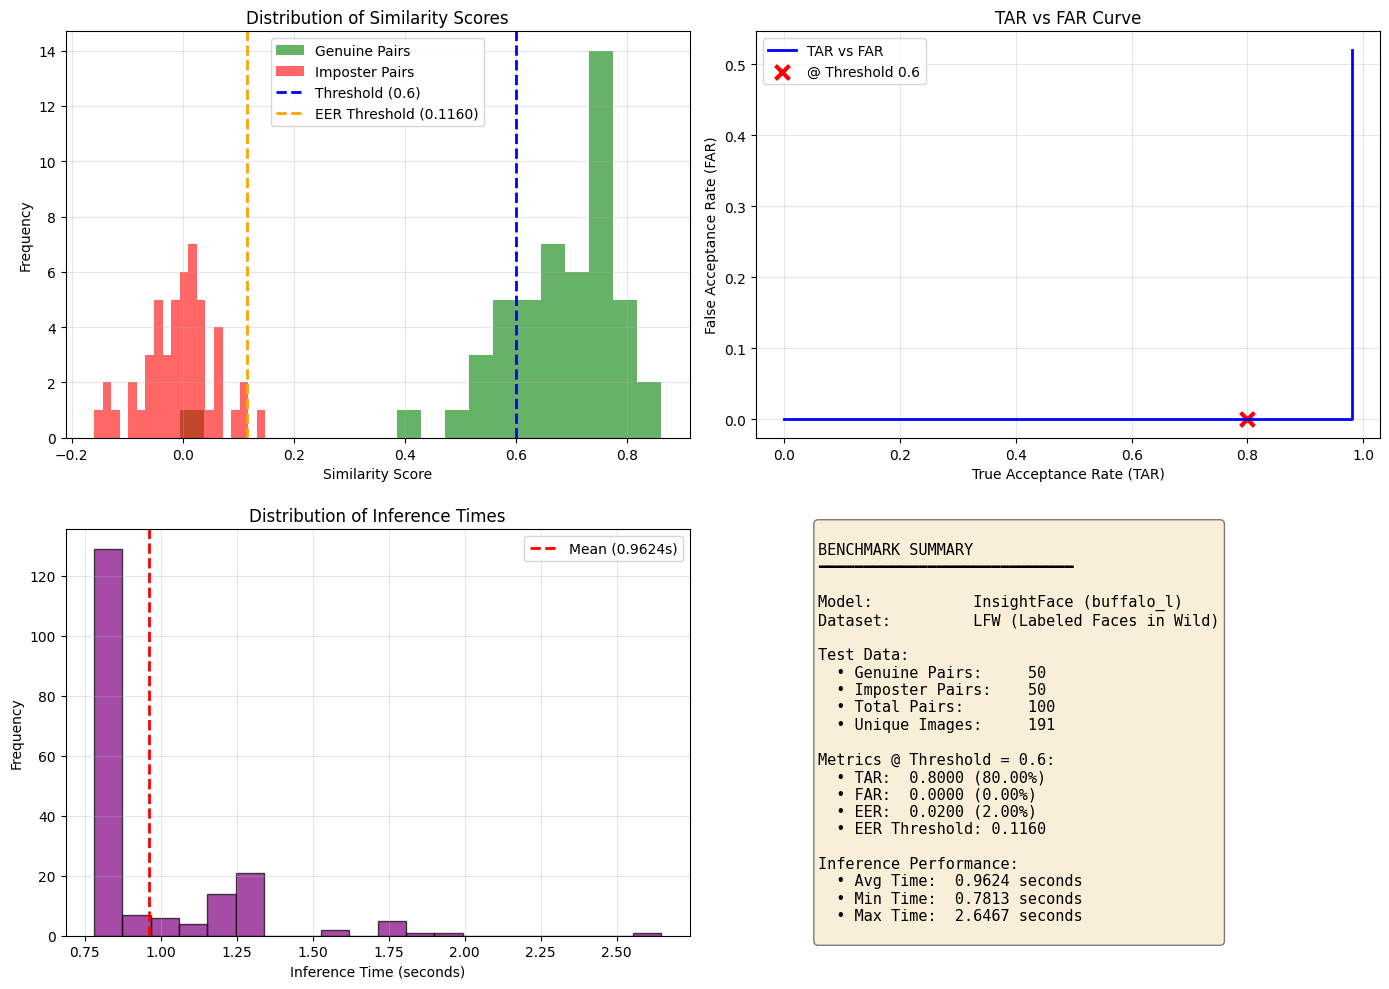


✓ Benchmark completed successfully!


In [34]:
import pandas as pd
import matplotlib.pyplot as plt

# Create comprehensive report
report = {
    'Model': ['InsightFace (buffalo_l)'],
    'Dataset': ['LFW'],
    'Genuine Pairs': [np.sum(labels)],
    'Imposter Pairs': [np.sum(labels == 0)],
    'Total Pairs': [len(labels)],
    'Threshold': [THRESHOLD],
    'TAR @ Threshold': [f"{tar:.4f} ({tar*100:.2f}%)"],
    'FAR @ Threshold': [f"{far:.4f} ({far*100:.2f}%)"],
    'EER': [f"{eer:.4f} ({eer*100:.2f}%)"],
    'EER Threshold': [f"{eer_threshold:.4f}"],
    'Avg Inference Time (s)': [f"{avg_inference_time:.4f}"],
    'Total Images': [len(inference_times)]
}

report_df = pd.DataFrame(report)

print("\n" + "="*100)
print("COMPREHENSIVE BENCHMARK REPORT - INSIGHTFACE BUFFALO_L ON LFW DATASET")
print("="*100)
print(report_df.to_string(index=False))
print("="*100)

# Save report to CSV - use absolute path
import os
output_dir = os.getcwd()
csv_path = os.path.join(output_dir, "benchmark_report.csv")
csv_abs_path = os.path.abspath(csv_path)
report_df.to_csv(csv_abs_path, index=False)
print(f"\n✓ Report saved to: {csv_abs_path}")

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Score distribution
ax = axes[0, 0]
ax.hist(scores[labels == 1], bins=20, alpha=0.6, label='Genuine Pairs', color='green')
ax.hist(scores[labels == 0], bins=20, alpha=0.6, label='Imposter Pairs', color='red')
ax.axvline(THRESHOLD, color='blue', linestyle='--', linewidth=2, label=f'Threshold ({THRESHOLD})')
ax.axvline(eer_threshold, color='orange', linestyle='--', linewidth=2, label=f'EER Threshold ({eer_threshold:.4f})')
ax.set_xlabel('Similarity Score')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Similarity Scores')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: ROC-like curve (TAR vs FAR)
ax = axes[0, 1]
thresholds_plot = np.arange(0.0, 1.01, 0.01)
tars_plot = []
fars_plot = []

for t in thresholds_plot:
    tar_t = np.sum(scores[labels == 1] >= t) / len(scores[labels == 1]) if np.sum(labels == 1) > 0 else 0
    far_t = np.sum(scores[labels == 0] >= t) / len(scores[labels == 0]) if np.sum(labels == 0) > 0 else 0
    tars_plot.append(tar_t)
    fars_plot.append(far_t)

ax.plot(tars_plot, fars_plot, 'b-', linewidth=2, label='TAR vs FAR')
ax.scatter([tar], [far], color='red', s=100, marker='x', linewidth=3, label=f'@ Threshold {THRESHOLD}')
ax.set_xlabel('True Acceptance Rate (TAR)')
ax.set_ylabel('False Acceptance Rate (FAR)')
ax.set_title('TAR vs FAR Curve')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Inference time distribution
ax = axes[1, 0]
ax.hist(inference_times, bins=20, color='purple', alpha=0.7, edgecolor='black')
ax.axvline(avg_inference_time, color='red', linestyle='--', linewidth=2, label=f'Mean ({avg_inference_time:.4f}s)')
ax.set_xlabel('Inference Time (seconds)')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Inference Times')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 4: Summary metrics table
ax = axes[1, 1]
ax.axis('off')
summary_text = f"""
BENCHMARK SUMMARY
━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Model:           InsightFace (buffalo_l)
Dataset:         LFW (Labeled Faces in Wild)

Test Data:
  • Genuine Pairs:     {np.sum(labels)}
  • Imposter Pairs:    {np.sum(labels == 0)}
  • Total Pairs:       {len(labels)}
  • Unique Images:     {len(embeddings_cache)}

Metrics @ Threshold = {THRESHOLD}:
  • TAR:  {tar:.4f} ({tar*100:.2f}%)
  • FAR:  {far:.4f} ({far*100:.2f}%)
  • EER:  {eer:.4f} ({eer*100:.2f}%)
  • EER Threshold: {eer_threshold:.4f}

Inference Performance:
  • Avg Time:  {avg_inference_time:.4f} seconds
  • Min Time:  {min_inference_time:.4f} seconds
  • Max Time:  {max_inference_time:.4f} seconds
"""

ax.text(0.1, 0.5, summary_text, fontsize=11, family='monospace',
        verticalalignment='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
png_path = os.path.join(output_dir, "benchmark_results.png")
png_abs_path = os.path.abspath(png_path)
plt.savefig(png_abs_path, dpi=150, bbox_inches='tight')
print(f"✓ Visualization saved to: {png_abs_path}")
plt.show()

print("\n✓ Benchmark completed successfully!")

## Additional Analysis: Metrics Across Multiple Thresholds


METRICS ACROSS MULTIPLE THRESHOLDS
Threshold    TAR    FAR    FRR  TAR % FAR %  FRR %
     0.40 0.9800 0.0000 0.0200 98.00% 0.00%  2.00%
     0.45 0.9600 0.0000 0.0400 96.00% 0.00%  4.00%
     0.50 0.9400 0.0000 0.0600 94.00% 0.00%  6.00%
     0.55 0.8800 0.0000 0.1200 88.00% 0.00% 12.00%
     0.60 0.8000 0.0000 0.2000 80.00% 0.00% 20.00%
     0.65 0.6600 0.0000 0.3400 66.00% 0.00% 34.00%
     0.70 0.5400 0.0000 0.4600 54.00% 0.00% 46.00%
     0.75 0.3200 0.0000 0.6800 32.00% 0.00% 68.00%
✓ Threshold analysis saved to: /content/threshold_analysis.png


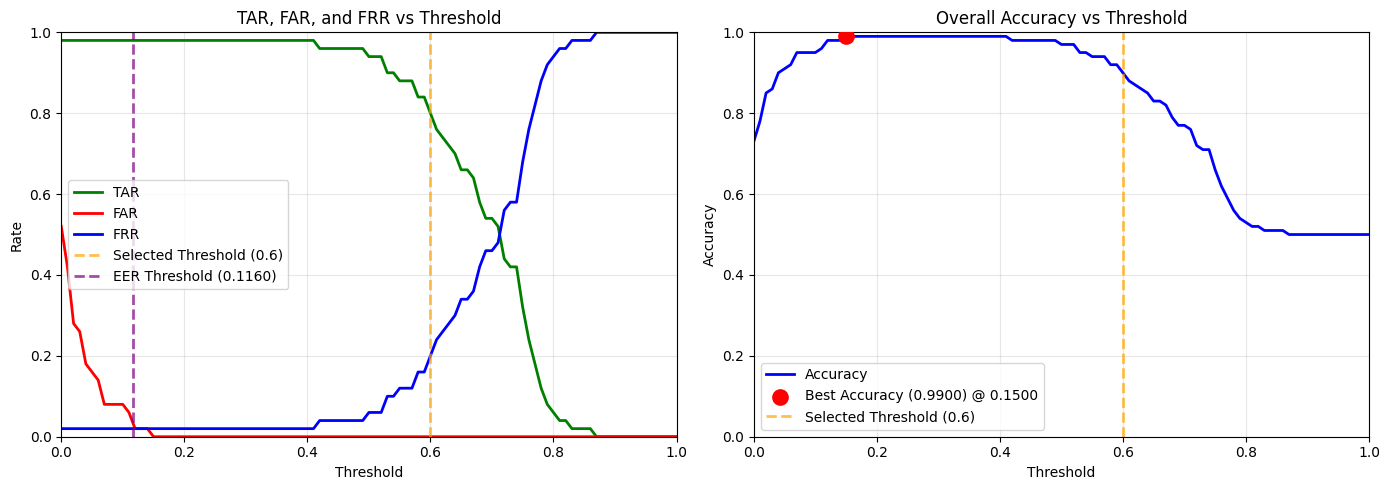


✓ Best threshold for overall accuracy: 0.1500 (Accuracy: 0.9900)


In [ ]:
import pandas as pd
import numpy as np

# Calculate metrics for multiple thresholds
test_thresholds = [0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75]
metrics_by_threshold = []

for t in test_thresholds:
    tar_t = np.sum(scores[labels == 1] >= t) / len(scores[labels == 1]) if np.sum(labels == 1) > 0 else 0
    far_t = np.sum(scores[labels == 0] >= t) / len(scores[labels == 0]) if np.sum(labels == 0) > 0 else 0
    frr_t = 1 - tar_t
    
    metrics_by_threshold.append({
        'Threshold': f'{t:.2f}',
        'TAR': f'{tar_t:.4f}',
        'FAR': f'{far_t:.4f}',
        'FRR': f'{frr_t:.4f}',
        'TAR %': f'{tar_t*100:.2f}%',
        'FAR %': f'{far_t*100:.2f}%',
        'FRR %': f'{frr_t*100:.2f}%'
    })

metrics_df = pd.DataFrame(metrics_by_threshold)

print("\n" + "="*100)
print("METRICS ACROSS MULTIPLE THRESHOLDS")
print("="*100)
print(metrics_df.to_string(index=False))
print("="*100)

# Create a detailed threshold analysis plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot TAR, FAR, FRR vs Threshold
ax = axes[0]
thresholds_fine = np.arange(0.0, 1.01, 0.01)
tars_fine = []
fars_fine = []
frrs_fine = []

for t in thresholds_fine:
    tar_t = np.sum(scores[labels == 1] >= t) / len(scores[labels == 1]) if np.sum(labels == 1) > 0 else 0
    far_t = np.sum(scores[labels == 0] >= t) / len(scores[labels == 0]) if np.sum(labels == 0) > 0 else 0
    frr_t = 1 - tar_t
    
    tars_fine.append(tar_t)
    fars_fine.append(far_t)
    frrs_fine.append(frr_t)

ax.plot(thresholds_fine, tars_fine, 'g-', linewidth=2, label='TAR')
ax.plot(thresholds_fine, fars_fine, 'r-', linewidth=2, label='FAR')
ax.plot(thresholds_fine, frrs_fine, 'b-', linewidth=2, label='FRR')
ax.axvline(THRESHOLD, color='orange', linestyle='--', linewidth=2, alpha=0.7, label=f'Selected Threshold ({THRESHOLD})')
ax.axvline(eer_threshold, color='purple', linestyle='--', linewidth=2, alpha=0.7, label=f'EER Threshold ({eer_threshold:.4f})')
ax.set_xlabel('Threshold')
ax.set_ylabel('Rate')
ax.set_title('TAR, FAR, and FRR vs Threshold')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

# Plot Accuracy vs Threshold
ax = axes[1]
accuracies = []
for t in thresholds_fine:
    predictions = (scores >= t).astype(int)
    accuracy = np.sum(predictions == labels) / len(labels)
    accuracies.append(accuracy)

best_accuracy_idx = np.argmax(accuracies)
best_threshold = thresholds_fine[best_accuracy_idx]
best_accuracy = accuracies[best_accuracy_idx]

ax.plot(thresholds_fine, accuracies, 'b-', linewidth=2, label='Accuracy')
ax.scatter([best_threshold], [best_accuracy], color='red', s=100, marker='o', 
           linewidth=2, label=f'Best Accuracy ({best_accuracy:.4f}) @ {best_threshold:.4f}', zorder=5)
ax.axvline(THRESHOLD, color='orange', linestyle='--', linewidth=2, alpha=0.7, label=f'Selected Threshold ({THRESHOLD})')
ax.set_xlabel('Threshold')
ax.set_ylabel('Accuracy')
ax.set_title('Overall Accuracy vs Threshold')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

plt.tight_layout()
import os
from pathlib import Path

# Get the notebook's directory (same logic as Cell 20)
try:
    import ipynbname
    notebook_path = Path(ipynbname.path()).resolve()
except:
    notebook_path = Path("lfw_insightface_benchmark.ipynb").resolve()
    if not notebook_path.exists():
        notebook_path = Path(os.getcwd()) / "lfw_insightface_benchmark.ipynb"

output_dir = notebook_path.parent if notebook_path.exists() else Path(os.getcwd())
threshold_path = output_dir / "threshold_analysis.png"

try:
    plt.savefig(str(threshold_path), dpi=150, bbox_inches='tight')
    print(f"✓ Threshold analysis saved to: {threshold_path}")
    print(f"  File exists: {threshold_path.exists()}")
    if threshold_path.exists():
        print(f"  File size: {threshold_path.stat().st_size} bytes")
except Exception as e:
    print(f"✗ Error saving threshold analysis: {e}")
    import traceback
    traceback.print_exc()
plt.show()

# Print best threshold
print(f"\n✓ Best threshold for overall accuracy: {best_threshold:.4f} (Accuracy: {best_accuracy:.4f})")